In [ ]:
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout,SimpleRNN
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

100%|██████████| 428M/428M [00:03<00:00, 138MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [ ]:
!mv "/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1" "/content"

In [ ]:
paths =[]
labels = []

for dirname, _, filenames in os.walk('/content/1/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is loaded')

Dataset is loaded


In [ ]:
df= pd.DataFrame()
df['speech']= paths
df['label']= labels
df.head()

,speech,label
0,/content/1/TESS Toronto emotional speech set d...,neutral
1,/content/1/TESS Toronto emotional speech set d...,neutral
2,/content/1/TESS Toronto emotional speech set d...,neutral
3,/content/1/TESS Toronto emotional speech set d...,neutral
4,/content/1/TESS Toronto emotional speech set d...,neutral


In [ ]:
df['label'].value_counts()

,count
label,
neutral,400
ps,400
disgust,400
happy,400
fear,400
sad,400
angry,400


In [ ]:
def extract_mfcc(filename):
    y,sr = librosa.load(filename, duration=3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 40).T, axis =0)
    return mfcc

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
df['label_count']= df['label'].value_counts()
df.drop('label_count', axis = 1)


,speech,label
0,/content/1/TESS Toronto emotional speech set d...,neutral
1,/content/1/TESS Toronto emotional speech set d...,neutral
2,/content/1/TESS Toronto emotional speech set d...,neutral
3,/content/1/TESS Toronto emotional speech set d...,neutral
4,/content/1/TESS Toronto emotional speech set d...,neutral
...,...,...
2795,/content/1/TESS Toronto emotional speech set d...,disgust
2796,/content/1/TESS Toronto emotional speech set d...,disgust
2797,/content/1/TESS Toronto emotional speech set d...,disgust
2798,/content/1/TESS Toronto emotional speech set d...,disgust


In [ ]:
X = [x for x in X_mfcc]
X = np.expand_dims(X, -1)
enc =  OneHotEncoder()
y = enc.fit_transform(df[['label']])
y=y.toarray()

In [ ]:
model = Sequential([
    SimpleRNN(128, return_sequences=False, input_shape=(40, 1)),
    Dense(64, activation= 'relu'),
    Dense(7, activation = 'softmax')

])
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,351 (99.03 KB)

 Trainable params: 25,351 (99.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs = 50, batch_size = 512, shuffle = True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.1970 - loss: 2.0944 - val_accuracy: 0.0429 - val_loss: 2.1172
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4432 - loss: 1.5286 - val_accuracy: 0.0018 - val_loss: 2.2743
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4960 - loss: 1.3168 - val_accuracy: 0.0875 - val_loss: 2.1649
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5946 - loss: 1.1650 - val_accuracy: 0.1536 - val_loss: 2.2754
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6118 - loss: 1.0547 - val_accuracy: 0.1268 - val_loss: 2.4001
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6377 - loss: 0.9613 - val_accuracy: 0.1446 - val_loss: 2.2955
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6640 - loss: 0.8952 - val_accuracy: 0.1607 - val_loss: 2.2257
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6977 - loss: 0.8289 - val_accuracy: 0.2232 - val_loss: 2.1334

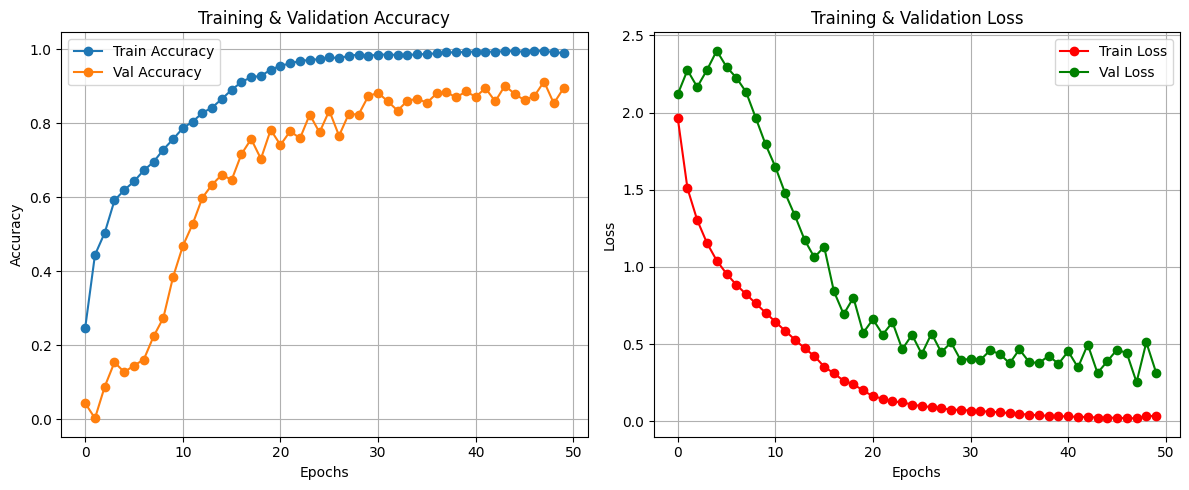

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(len(history.history['accuracy'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, acc, label='Train Accuracy', marker='o')
axes[0].plot(epochs, val_acc, label='Val Accuracy', marker='o')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training & Validation Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, loss, label='Train Loss', marker='o', color='red')
axes[1].plot(epochs, val_loss, label='Val Loss', marker='o', color='green')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training & Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.9704


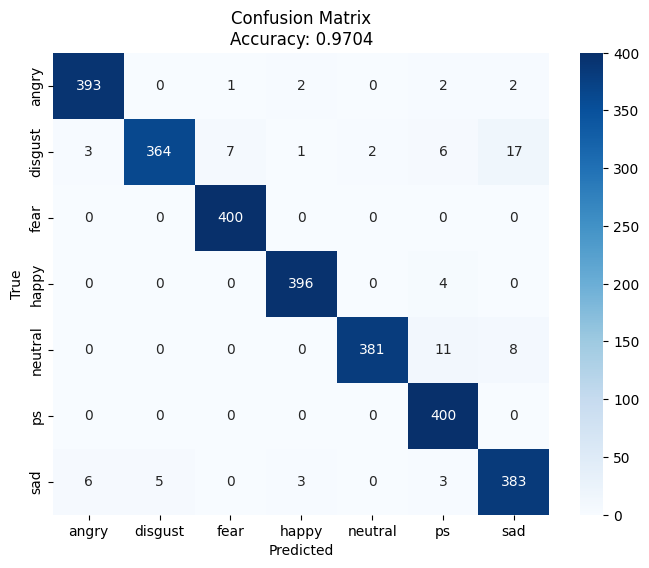

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Dự đoán xác suất
y_pred_probs = model.predict(X)

# Chuyển đổi xác suất thành nhãn dự đoán
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y, axis=1)

# Tính độ chính xác
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}')
plt.show()
